INSPER - Big Data e Computação em Nuvem

# Big Data e Computação em Nuvem - Projeto Final: Análise de Atraso de Voos

**Integrantes**:

- Flávio Barbosa Shirahige
- Hélio Pereira de Oliveira
- Michel Maurice Conjaud Neto

# 1. Introdução

A aviação é em uma das maiores indústrias da ecomonia global. Apesar do seu potencial de faturamento, há desafios logísticos na alocação de aeronaves que impactam a margem do negócio nessa indústria. Desta forma, o cumprimento da programação de voos acaba se tornando um diferencial para uma empresa.

No entanto, sabemos que há fatores que impactam o cumprimento desta programação e estão além das decisões de uma companhia, como as condições climáticas. Portanto, ter um modelo que preveja se um voo atrasará ou não em determinado aeroporto se torna vital para a obtenção de uma margem significativa. 

O objetivo deste projeto é criar um modelo que preveja se um voo tem potencial para atrasar para que seja possível ter uma melhor acurácia na programação de voos e minimizar as perdas em decorrência da logítica. 

# 2. Importando as bibliotecas e dados e criando a sessão do Spark

In [1]:
#Importando as bibliotecas necessárias
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import StringType, FloatType
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, sum, when, stddev, mean, count, isnan
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
from sklearn.metrics import auc, roc_curve
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Criar a sessao do Spark
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_<mudar-nome>") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "5g")\
            .getOrCreate()

In [3]:
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

Abaixo, vamos importar os dados de voos nos EUA de 2012 para não onerar o processamento das informações, dado a limitação de recursos disponíveis.

In [4]:
# Importar os dados de 2012
df = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2012.csv".format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, inferSchema=True)

In [5]:
#Visualizar a estrutura dos dados importados
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

Nota-se que dados importados estão no formato adequado para a modelagem. As únicas exceções são CRS_DEP_TIME, DEP_TIME, WHEELS_OFF, WHEELS_ON, CRS_ARR_TIME e ARR_TIME, pois são variáveis que medem o horário (timestamp), mas estão em formato numérico (double). O tratamento destas variáveis será feito na próxima etapa.

# 3. Feature Engineering

Inicialmente vamos excluir a coluna "Unnamed: 27",que não será utilizada por não está no dicionário de dados

In [6]:
# Colocar em cache, pois os códigos de contagem são lentos
df.cache()

DataFrame[FL_DATE: timestamp, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: double, DEP_TIME: double, DEP_DELAY: double, TAXI_OUT: double, WHEELS_OFF: double, WHEELS_ON: double, TAXI_IN: double, CRS_ARR_TIME: double, ARR_TIME: double, ARR_DELAY: double, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, Unnamed: 27: string]

In [6]:
#Remover a coluna Unnamed
df = df.drop("Unnamed: 27")
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

In [7]:
# numero de linhas
total_rows = df.count()
print("O total de linhas do dataframe é: ", total_rows)

O total de linhas do dataframe é:  6096762


## 3.2 Definição e Criação da Variável Resposta

Como o objetivo é ter um input para a programação de voos, qualquer informação sobre atraso de voos na decolagem ou na aterrissagem importa. Logo, o atraso será definido a partir da soma das coluna DEP_DELAY (atraso na decolagem) e ARR_DELAY (atraso na aterrissagem), sem tolerência de atraso (DEP_DELAY + ARR_DELAY > 0).

In [8]:
#Criar a variável reposta a partir da soma das colunas ARR_DELAY DEP_DELAY
df = df.withColumn("DELAY", 
                   when(df['ARR_DELAY'] +  df['DEP_DELAY'] > 0, 1)
                   .otherwise(0))

## 3.3 Análise de Variáveis do Dataset

Nessa etapa vamos analisar os missing values.

In [9]:
#Verificando os missing values
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'FL_DATE': 0,
 'OP_CARRIER': 0,
 'OP_CARRIER_FL_NUM': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'CRS_DEP_TIME': 1,
 'DEP_TIME': 75723,
 'DEP_DELAY': 75723,
 'TAXI_OUT': 77977,
 'WHEELS_OFF': 77977,
 'WHEELS_ON': 80894,
 'TAXI_IN': 80894,
 'CRS_ARR_TIME': 2,
 'ARR_TIME': 80894,
 'ARR_DELAY': 91381,
 'CANCELLED': 0,
 'CANCELLATION_CODE': 6017900,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 1,
 'ACTUAL_ELAPSED_TIME': 91381,
 'AIR_TIME': 91381,
 'DISTANCE': 0,
 'CARRIER_DELAY': 5081604,
 'WEATHER_DELAY': 5081604,
 'NAS_DELAY': 5081604,
 'SECURITY_DELAY': 5081604,
 'LATE_AIRCRAFT_DELAY': 5081604,
 'DELAY': 0}

As variáveis de atraso têm um valor de missing values elevado. Vamos analisar a distribuição destes dados.

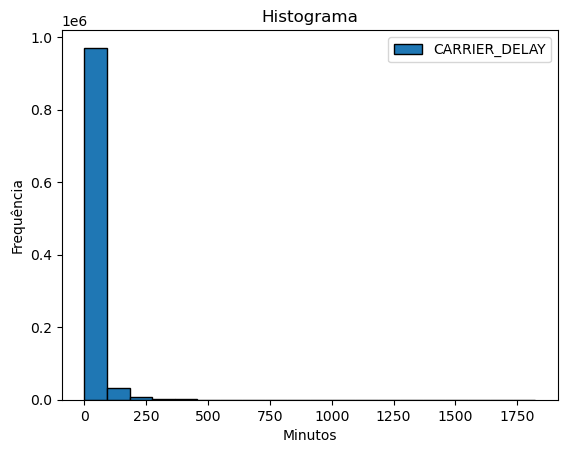

In [10]:
# Cria um dataframe com os dados da coluna CARRIER_DELAY
df_carrier_delay = df.select(df['CARRIER_DELAY']).toPandas()

# Plota histograma das distâncias com 20 bins para verificar a distribuição dos voos
df_carrier_delay.plot.hist(bins=20, edgecolor='black')
plt.title('Histograma')
plt.xlabel('Minutos')
plt.ylabel('Frequência')
plt.show()

In [11]:
df.select('CARRIER_DELAY').describe().toPandas()

,summary,CARRIER_DELAY
0,count,1015158
1,mean,17.89421548172797
2,stddev,45.56229030399185
3,min,0.0
4,max,1823.0


In [12]:
df.select('WEATHER_DELAY').describe().toPandas()

,summary,WEATHER_DELAY
0,count,1015158
1,mean,2.2457686389704854
2,stddev,17.272722643396154
3,min,0.0
4,max,1615.0


In [13]:
df.select('NAS_DELAY').describe().toPandas()

,summary,NAS_DELAY
0,count,1015158
1,mean,12.637266317164421
2,stddev,25.90985229314727
3,min,0.0
4,max,1207.0


In [14]:
df.select('SECURITY_DELAY').describe().toPandas()

,summary,SECURITY_DELAY
0,count,1015158
1,mean,0.07196121194927292
2,stddev,2.110994781167227
3,min,0.0
4,max,717.0


In [15]:
df.select('LATE_AIRCRAFT_DELAY').describe().toPandas()

,summary,LATE_AIRCRAFT_DELAY
0,count,1015158
1,mean,23.217619326252663
2,stddev,41.40641306888853
3,min,0.0
4,max,1201.0


In [16]:
df.select('CANCELLATION_CODE').describe().toPandas()

,summary,CANCELLATION_CODE
0,count,78862
1,mean,None
2,stddev,None
3,min,A
4,max,D


Os missing values das colunas CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, VLATE_AIRCRAFT_DELAY possivelmente são zero minutos de atraso. Logo, vamos preencher os missing values dessas colunas com ZERO. No entanto, verifica-se que há valores muito altos de atraso. Como algumas normas internacionais estabelacem que um voo cima de 3 horas de atraso pode ser cancelado pela companhia aérea, vamos excluir essas informações do dataset.

No mais, verificamos que a coluna CANCELLATION_CODE possui um número extremamente elevado de missing values. Logo, vamos excluí-la.

## 3.4 Criação de novas colunas

Serão criadas novas colunas que a serão utilizadas na etapa de modelagem, a saber:

 - MONTH: coluna com o mês do voo;
 - GENERAL_DELAY: informação se o voo tem um atraso acima de 180 minutos em qualquer um dos quesitos (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, VLATE_AIRCRAFT_DELAY);
 - DEP_PERIOD: é uma variável com o período que o voo saiu (manha, tarde, noite, madrugada);
 - ARR_PERIOD: é uma variável com o período que o voo chegou (manha, tarde, noite, madrugada);
 - DISTANCE_TYPE: é coluna com o tipo de distância entre os aeroportos dos voos (perto, médio e distante).

In [17]:
# Criar uma variável com o mês do voo
df = df.withColumn('FL_MONTH', f.month(df.FL_DATE))

In [18]:
# Criando filtro dos Outliers com atraso > 180 minutos (Critério Europeu)
df = df.withColumn("GENERAL_DELAY", 
                   when((df['CARRIER_DELAY'] > 180) | (df['WEATHER_DELAY'] > 180) | (df['NAS_DELAY'] > 180) | (df['SECURITY_DELAY'] > 180) |
                        (df['LATE_AIRCRAFT_DELAY'] > 180) ,1)
                   .otherwise(0))

In [19]:
# Criar uma variável o período que o voo saiu (manha, tarde, noite, madrugada)
df = df.withColumn("DEP_PERIOD", 
                   when((df['DEP_TIME'] >= 0) & (df['DEP_TIME'] < 600), "Madrugada")
                   .when((df['DEP_TIME'] >= 600) & (df['DEP_TIME'] < 1200), "Manha")
                   .when((df['DEP_TIME'] >= 1200) & (df['DEP_TIME'] < 1800), "Tarde")
                   .when((df['DEP_TIME'] >= 1800) & (df['DEP_TIME'] <= 2400), "Noite")
                   .otherwise("Nao Identificado"))

In [20]:
# Criar uma variável o período que o voo chegou (manha, tarde, noite, madrugada)
df = df.withColumn("ARR_PERIOD", 
                   when((df['ARR_TIME'] >= 0) & (df['ARR_TIME'] < 600), "Madrugada")
                   .when((df['ARR_TIME'] >= 600) & (df['ARR_TIME'] < 1200), "Manha")
                   .when((df['ARR_TIME'] >= 1200) & (df['ARR_TIME'] < 1800), "Tarde")
                   .when((df['ARR_TIME'] >= 1800) & (df['ARR_TIME'] <= 2400), "Noite")
                   .otherwise("Nao Identificado"))

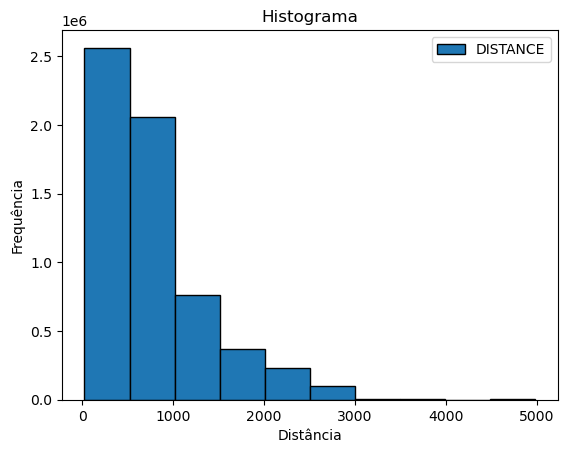

In [21]:
# Cria um dataframe com os dados da coluna DISTANCE
df_distance = df.select(df['DISTANCE']).toPandas()

# Plota histograma das distâncias com 10 bins para verificar a distribuição dos voos
df_distance.plot.hist(bins=10, edgecolor='black')
plt.title('Histograma')
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.show()

A partir do histograma acima, vamos definir o seguinte critério para classificar as distâncias:

- próximo: abaixo de 500 milhas
- médio: entre 500 e 1000 milhas
- distante: acima de 1000 milhas

In [22]:
#Criar coluna "Tipo de Distância" com o critério acima
df = df.withColumn("DISTANCE_TYPE", 
                   when(df['DISTANCE'] > 1000, "distant")
                   .when(df['DISTANCE'] > 500, "medium")
                   .otherwise("near"))

## 3.5 Tratamento final dos dados: exclusão de linhas e dolunas do dataset e preenchendo os missing values

Primeiramente, vamos filtrar os voos cancelados, uma vez que não há atraso em relação a eles.

In [23]:
df = df.filter(df['GENERAL_DELAY'] == 0)

A próxima etapa é excluir as linhas com missing values das colunas 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', pois representam menos de 1%.

In [24]:
#tratar os missing values (inicialmente coloquei para excluir todas as linhas que tem missing values, pois representam menos de 1% )
df = df.na.drop(subset=['AIR_TIME', 'ACTUAL_ELAPSED_TIME'])

Agora, vamos remover as colunas que não serão utilizadas:

 - FL_DATE: coluna de data. Será excluída, pois vamos usar a coluna MONTH para verificar alguma sazonalidade
 - OP_CARRIER_FL_NUM: ID do voo;
 - CRS_DEP_TIME, DEP_TIME, DEP_DELAY, WHEELS_OFF, ARR_TIME, ARR_DELAY, WHEELS_ON e CRS_ARR_TIME: informação do horário planejado do voo. Esta informação já está em DELAY;
 - CANCELLED: foram filtrados os valores, restando apenas ZERO nessa coluna;
 - CANCELLATION_CODE: não possui valores;
 - GENERAL_DELAY: há apenas 1 valor (0).

In [25]:
#Removendo colunas que não serão utilizadas
df = df.drop('FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON',
                   'CRS_ARR_TIME', 'ARR_TIME', 'OP_CARRIER_FL_NUM', 'ARR_DELAY', 
                  'DEP_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'GENERAL_DELAY')

Por fim, vamos preencher os missing values das colunas abaixo com ZERO:

- CARRIER_DELAY
- WEATHER_DELAY
- NAS_DELAY
- SECURITY_DELAY
- LATE_AIRCRAFT_DELAY

In [26]:
df = df.na.fill(0, subset=["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"])

Abaixo, vamos confirmar se todos os missign values foram tratados.

In [27]:
#Verificando se as linhas com missing values foram excluiídas
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 0,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 0,
 'ACTUAL_ELAPSED_TIME': 0,
 'AIR_TIME': 0,
 'DISTANCE': 0,
 'CARRIER_DELAY': 0,
 'WEATHER_DELAY': 0,
 'NAS_DELAY': 0,
 'SECURITY_DELAY': 0,
 'LATE_AIRCRAFT_DELAY': 0,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

Por último, vamos confirmar se não há valores negativos atípicos.

In [28]:
# Verificar se há valores negativos
def conta_negativo(coluna):
    try: 
        return df.filter((df[coluna]<0)).count()
    except:
        return "Variável não numérica"

{col:conta_negativo(col) for col in df.columns}

{'OP_CARRIER': 0,
 'ORIGIN': 0,
 'DEST': 0,
 'TAXI_OUT': 0,
 'TAXI_IN': 0,
 'DIVERTED': 0,
 'CRS_ELAPSED_TIME': 0,
 'ACTUAL_ELAPSED_TIME': 0,
 'AIR_TIME': 0,
 'DISTANCE': 0,
 'CARRIER_DELAY': 0,
 'WEATHER_DELAY': 0,
 'NAS_DELAY': 0,
 'SECURITY_DELAY': 0,
 'LATE_AIRCRAFT_DELAY': 0,
 'DELAY': 0,
 'FL_MONTH': 0,
 'DEP_PERIOD': 0,
 'ARR_PERIOD': 0,
 'DISTANCE_TYPE': 0}

# 4. Analise Gráfica do Dataset

Primeiramente, vamos ver os voos atrasados ao longo do meses de 2012:

In [29]:
df_month = df.filter((df['DELAY']==1)).groupBy("FL_MONTH").count().toPandas()
df_month = df_month.sort_values('FL_MONTH')

# Gráfico de atrasos vs. total de voos ao longo dos meses

<AxesSubplot: xlabel='FL_MONTH'>

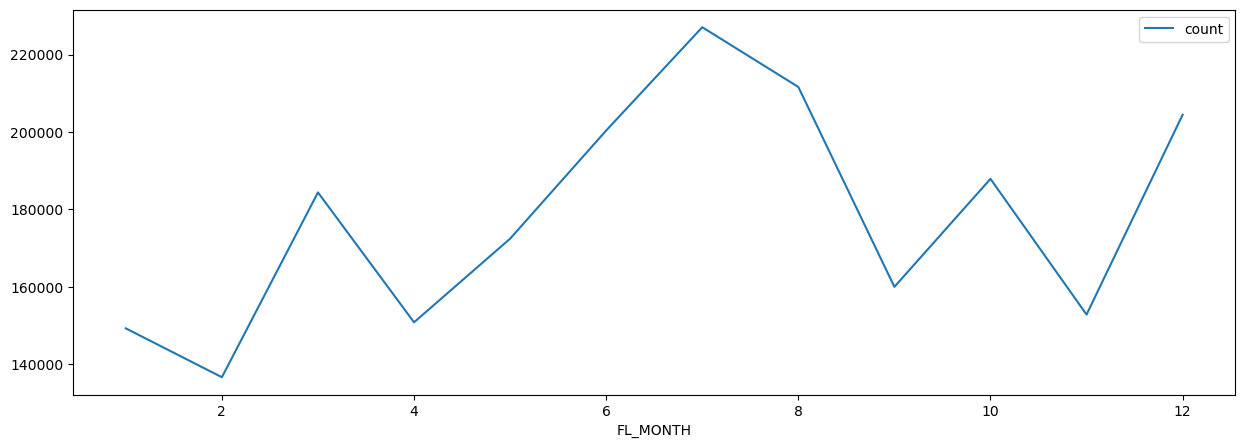

In [30]:
df_month.set_index("FL_MONTH").plot(figsize=(15,5))

Há um pico de atrasos de voos no verão.

# ORIGIN aeroportos com maior numero de atrasos (em %)

In [31]:

#Total de voos por ORIGIN
flights_by_origin = df.groupBy("ORIGIN").count()
#Total de voos atrasados por ORIGIN
delayed_flights_by_origin = df.filter((df['DELAY']==1)).groupBy("ORIGIN").count()
# Alias the count columns to avoid naming conflicts
flights_by_origin = flights_by_origin.withColumnRenamed("count", "total_count")
delayed_flights_by_origin = delayed_flights_by_origin.withColumnRenamed("count", "delayed_count")
#Realizando um filtro para contar apenas os aeroporto que possuem mais que 1000 voos em atraso
delayed_flights_by_origin = delayed_flights_by_origin.filter(delayed_flights_by_origin["delayed_count"] > 1000)
#Relação entre Voos atrasado e Voos no tempo por ORIGIN
# Join the DataFrames to get the total and delayed flights in the same DataFrame
flights_relation_by_origin = flights_by_origin.join(delayed_flights_by_origin, 
                                                          "ORIGIN", "left_outer")
#Nome das colunas do DF flights_relation_by_origin ['ORIGIN','total_count','delayed_count','Percentage_Delayed']
# Calculate the percentage of delayed flights
flights_relation_by_origin = flights_relation_by_origin.withColumn("Percentage_Delayed", 
                                                                   (flights_relation_by_origin["delayed_count"] 
                                                                    / flights_relation_by_origin["total_count"]) * 100)
# Ordenas por porcentagem de voos atrasados baseado no aeroporto de Origem
flights_relation_by_origin = flights_relation_by_origin.orderBy("total_count", ascending=False)

In [33]:
# Sort the DataFrame by total count in descending order and select the top 20
top_20_graph = percentage_graph.sort_values(by="total_count", ascending=False).head(5)

# Create the bar chart
fig, ax = plt.subplots()
bar_width = 0.35

ax.bar(percentage_graph["ORIGIN"] + "-", percentage_graph["Percentage_Delayed"], bar_width, color='red', label='Delayed')
ax.bar(percentage_graph["ORIGIN"] + "-", 100 - percentage_graph["Percentage_Delayed"], bar_width, bottom=percentage_graph["Percentage_Delayed"], color='green', label='NOT DELAYED')

ax.set_xlabel('Origin')
ax.set_ylabel('Percentage of Flights')
ax.set_title('Porcentagem de Voos com Atraso por Origem (Top 10)')
ax.legend()

plt.show()

NameError: name 'percentage_graph' is not defined

In [32]:
flights_relation_by_origin.show()

+------+-----------+-------------+------------------+
|ORIGIN|total_count|delayed_count|Percentage_Delayed|
+------+-----------+-------------+------------------+
|   ATL|     387820|       123605|31.871744623794545|
|   ORD|     302383|       126450|41.817827060383685|
|   DFW|     265899|       118766| 44.66583176318828|
|   DEN|     232420|       104336| 44.89114534033216|
|   LAX|     219152|        91082| 41.56110827188436|
|   PHX|     181394|        67380|37.145660826708706|
|   IAH|     173927|        79453| 45.68180903482496|
|   SFO|     165703|        77580|46.818705756685155|
|   LAS|     140467|        57263|40.766158599528715|
|   CLT|     134318|        43730| 32.55706606709451|
|   MCO|     118514|        41156| 34.72669895539767|
|   EWR|     114778|        50427| 43.93437766819425|
|   SLC|     109295|        31274|28.614300745688276|
|   MSP|     109242|        29820|27.297193387158785|
|   BWI|     101065|        42997|42.543907386335526|
|   BOS|     101001|        

# DEST aeroportos com maior numero de atrasos (em %)

In [33]:
#Total de voos por DEST
flights_by_dest = df.groupBy("DEST").count()
#Total de voos atrasados por ORIGIN
delayed_flights_by_dest = df.filter((df['DELAY']==1)).groupBy("DEST").count()
# Alias the count columns to avoid naming conflicts
flights_by_dest = flights_by_dest.withColumnRenamed("count", "total_count")
delayed_flights_by_dest = delayed_flights_by_dest.withColumnRenamed("count", "delayed_count")
#Realizando um filtro para contar apenas os aeroporto que possuem mais que 1000 voos em atraso
delayed_flights_by_dest = delayed_flights_by_dest.filter(delayed_flights_by_dest["delayed_count"] > 1000)
#Relação entre Voos atrasado e Voos no tempo por ORIGIN
# Join the DataFrames to get the total and delayed flights in the same DataFrame
flights_relation_by_dest = flights_by_dest.join(delayed_flights_by_dest, 
                                                          "DEST", "left_outer")
# Calculate the percentage of delayed flights
flights_relation_by_dest = flights_relation_by_dest.withColumn("Percentage_Delayed", 
                                                                   (flights_relation_by_dest["delayed_count"] 
                                                                    / flights_relation_by_dest["total_count"]) * 100)
# Ordenas por porcentagem de voos atrasados baseado no aeroporto de Origem
flights_relation_by_dest = flights_relation_by_dest.orderBy("total_count", ascending=False)

In [34]:
flights_relation_by_dest.show()

+----+-----------+-------------+------------------+
|DEST|total_count|delayed_count|Percentage_Delayed|
+----+-----------+-------------+------------------+
| ATL|     386119|       118164| 30.60300062933966|
| ORD|     300692|       100603|33.457158820321126|
| DFW|     264272|        83556|31.617424471756372|
| DEN|     232081|        86064| 37.08360443121151|
| LAX|     219193|        85767| 39.12853056438846|
| PHX|     181082|        58855| 32.50184999061199|
| IAH|     173260|        65872| 38.01916195313402|
| SFO|     164813|        76348|46.324015702644814|
| LAS|     140836|        52224| 37.08142804396603|
| CLT|     134075|        38471| 28.69364161849711|
| MCO|     118657|        43408| 36.58275533681115|
| EWR|     115057|        53023| 46.08411483004076|
| SLC|     109206|        30677| 28.09094738384338|
| MSP|     109048|        29940|27.455799281050545|
| BWI|     101105|        38937|38.511448494139756|
| BOS|     101103|        35043|  34.6606925610516|
| SEA|      

# Grafico dois eixos % por aeroporto vs total de voos por aeroporto

In [35]:
# Calcule a porcentagem de voos com atraso para cada aeroporto
total_voos = df.groupBy("ORIGIN", "DEST").count()
voos_com_atraso = df.filter(df["DELAY"]==1).groupBy("ORIGIN").count()
# Order the DataFrame by count in descending order
total_voos = total_voos.orderBy("count", ascending=False)
# Sum the counts of the top 20 origin-destination pairs
sum_top_20_counts = total_voos.limit(20).agg({"count": "sum"})

In [36]:
total_voos.show()

+------+----+-----+
|ORIGIN|DEST|count|
+------+----+-----+
|   SFO| LAX|17044|
|   LAX| SFO|16701|
|   OGG| HNL|12723|
|   HNL| OGG|12675|
|   JFK| LAX|11609|
|   LAX| JFK|11562|
|   LAX| LAS|10928|
|   LAS| LAX|10627|
|   ATL| LGA|10523|
|   LGA| ATL|10518|
|   LAX| SAN| 9938|
|   SAN| LAX| 9905|
|   PHX| LAX| 9753|
|   LAX| PHX| 9747|
|   ATL| MCO| 9031|
|   MCO| ATL| 8977|
|   LGA| ORD| 8916|
|   ORD| LGA| 8774|
|   HNL| LIH| 8694|
|   LIH| HNL| 8611|
+------+----+-----+
only showing top 20 rows



In [37]:
df_test = df.filter((df['DELAY']==1)).count()
print(df_test)

2137815


In [38]:
df_test = df.filter((df['DELAY']==1)).count()
print(df_test)

2137815


In [39]:
sum_top_20_counts.show()

+----------+
|sum(count)|
+----------+
|    217256|
+----------+



## Matriz de Correlação

In [40]:
# verificar quais são as colunas numéricas
colunas_numericas = [coluna for coluna, tipo in df.dtypes if tipo in ['int', 'double']]
# Selecionar apenas colunas numéricas
df_numericas = df.select(*colunas_numericas)
df_numericas.printSchema()

root
 |-- TAXI_OUT: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = false)
 |-- WEATHER_DELAY: double (nullable = false)
 |-- NAS_DELAY: double (nullable = false)
 |-- SECURITY_DELAY: double (nullable = false)
 |-- LATE_AIRCRAFT_DELAY: double (nullable = false)
 |-- DELAY: integer (nullable = false)
 |-- FL_MONTH: integer (nullable = true)



<AxesSubplot: >

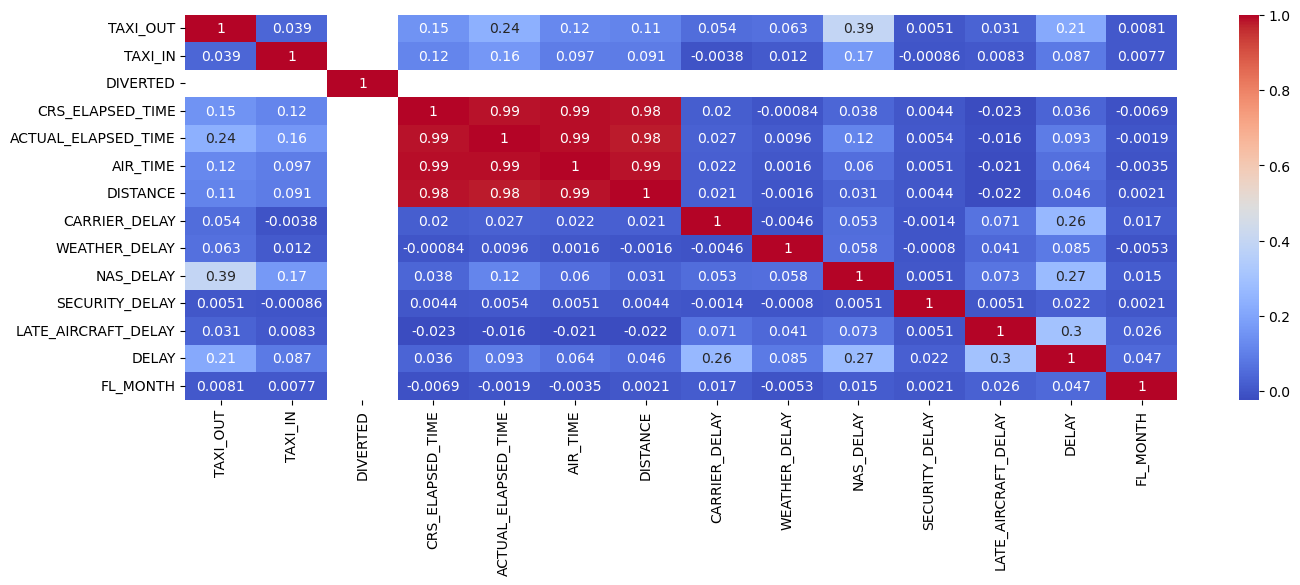

In [41]:
# converter para um coluna vetor 
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_numericas.columns, outputCol=vector_col)
df_vector = assembler.transform(df_numericas).select(vector_col)

# Obter a matriz de correlação
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()
corr_matrix = matrix.tolist() 

# Colocar as correlações das variáveis num dataframe em pandas
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df_numericas.columns, index=df_numericas.columns)

# Plotar a matriz
plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="coolwarm", annot=True)

# 5. Modelagem

## 5.1 Separação entre Treino e Teste

In [42]:
# criar df de treino e teste
train_df, test_df = df.randomSplit( [0.8, 0.2], seed=42)

In [43]:
# criar df para tunar os hiperparametros
toy_df = test_df.sample(False, 0.01, seed=42)

In [44]:
print("Train set count: ", train_df.count())
print("Train set count: ", test_df.count())
print("Train set count: ", toy_df.count())

Train set count:  4779318
Train set count:  1195976
Train set count:  12055


## 5.2 Tratamento das Variáveis Categóricas: One Hot Encoding

In [45]:
#Preparar para converter as colunas categóricas pelo one hot encoding (coloque o FL_MONTH como categórica)
cat_features = ['OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_PERIOD', 'ARR_PERIOD', 'DISTANCE_TYPE', 'FL_MONTH']

indexOutputCols = [x + 'Index' for x in cat_features]
oheOutputCols = [x + 'OHE' for x in cat_features]
stringIndexer = StringIndexer(inputCols=cat_features,
                             outputCols=indexOutputCols,
                             handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

## 5.3 Tratamento das Variáveis Numéricas: Normalização

In [46]:
#Preparar para converter as colunas númericas
num_features = ['TAXI_OUT', 'TAXI_IN', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
                'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY',
                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

numVecAssembler = VectorAssembler(inputCols = num_features, outputCol = 'features')

stadScaler = StandardScaler(inputCol = 'features', outputCol = 'features_scaled')

## 5.4 Juntando os Vetores de One Hot Encoding e Normalização

In [47]:
assemblerInputs = oheOutputCols + ['features_scaled']

VecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features_vector')

In [48]:
stages = [stringIndexer, oheEncoder, numVecAssembler, stadScaler, VecAssembler]

## 5.5 Criação do Pipeline de Transformação do Dados

In [49]:
# Criacao do pipeline de transformacao
transform_pipeline = Pipeline(stages=stages)

#aplicacao do pipeline nos dados treino - ajuste da transformacao
fitted_transformer = transform_pipeline.fit(train_df)

#aplicacao da transformacao nos dados de treino
transformed_train_df = fitted_transformer.transform(train_df)

transformed_train_df.limit(5).toPandas()

,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,TAXI_IN,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,...,OP_CARRIEROHE,ORIGINOHE,DESTOHE,DEP_PERIODOHE,ARR_PERIODOHE,DISTANCE_TYPEOHE,FL_MONTHOHE,features,features_scaled,features_vector
0,AA,ABQ,DFW,5.0,3.0,0.0,100.0,81.0,73.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 3.0, 0.0, 100.0, 81.0, 73.0, 569.0, 0.0,...","(0.5993661005164417, 0.6374333053965965, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,AA,ABQ,DFW,5.0,10.0,0.0,100.0,87.0,72.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.0, 10.0, 0.0, 100.0, 87.0, 72.0, 569.0, 0.0...","(0.5993661005164417, 2.1247776846553217, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,AA,ABQ,DFW,6.0,4.0,0.0,105.0,82.0,72.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 4.0, 0.0, 105.0, 82.0, 72.0, 569.0, 0.0,...","(0.71923932061973, 0.8499110738621286, 0.0, 1....","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,AA,ABQ,DFW,6.0,5.0,0.0,100.0,85.0,74.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 5.0, 0.0, 100.0, 85.0, 74.0, 569.0, 0.0,...","(0.71923932061973, 1.0623888423276608, 0.0, 1....","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,AA,ABQ,DFW,6.0,6.0,0.0,100.0,95.0,83.0,569.0,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 0.0, 100.0, 95.0, 83.0, 569.0, 0.0,...","[0.71923932061973, 1.274866610793193, 0.0, 1.3...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


## 5.2 Regressão Logísitica

### 5.2.1 Treinamento do Modelo

In [50]:
log_reg = LogisticRegression(featuresCol='features_vector', labelCol='DELAY') 

pipe_stages_log_reg = stages + [log_reg]
pipe_log_reg  = Pipeline(stages=pipe_stages_log_reg )

In [51]:
fitted_pipe_log_reg = pipe_log_reg.fit(train_df)

In [52]:
pred_log_reg = fitted_pipe_log_reg.transform(test_df)

### 5.2.2 Avaliação do Modelo

In [53]:
# Crie um avaliador de classificação multiclasse
evaluator = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction", metricName="accuracy")

# Avalie o modelo e obtenha a matriz de confusão
accuracy_log = evaluator.evaluate(pred_log_reg)
print(f"Acurácia da Regressão Logística: {accuracy_log}")

# Matriz de confusão
y_true_log = pred_log_reg.select(['DELAY']).collect()
y_pred_log = pred_log_reg.select(['prediction']).collect()

print(classification_report(y_true_log, y_pred_log))

Acurácia da Regressão Logística: 0.8264271189388416
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    767186
           1       0.91      0.57      0.70    428790

    accuracy                           0.83   1195976
   macro avg       0.86      0.77      0.79   1195976
weighted avg       0.84      0.83      0.81   1195976



In [54]:
pred_log_reg_pd = pred_log_reg.select('DELAY', 'prediction', 'probability').toPandas()
pred_log_reg_pd.head()

,DELAY,prediction,probability
0,0,0.0,"[0.9349190257357293, 0.06508097426427073]"
1,0,0.0,"[0.9487541029638428, 0.05124589703615723]"
2,0,0.0,"[0.7577562567252812, 0.24224374327471876]"
3,0,0.0,"[0.9111314879139608, 0.08886851208603919]"
4,0,0.0,"[0.9261097432136534, 0.07389025678634664]"


In [55]:
pred_log_reg_pd['probability'] = pred_log_reg_pd['probability'].map(lambda x: list(x))
pred_log_reg_pd['encoded_DELAY'] = pred_log_reg_pd['DELAY'].map(lambda x: np.eye(2)[int(x)])
pred_log_reg_pd.head()

,DELAY,prediction,probability,encoded_DELAY
0,0,0.0,"[0.9349190257357293, 0.06508097426427073]","[1.0, 0.0]"
1,0,0.0,"[0.9487541029638428, 0.05124589703615723]","[1.0, 0.0]"
2,0,0.0,"[0.7577562567252812, 0.24224374327471876]","[1.0, 0.0]"
3,0,0.0,"[0.9111314879139608, 0.08886851208603919]","[1.0, 0.0]"
4,0,0.0,"[0.9261097432136534, 0.07389025678634664]","[1.0, 0.0]"


In [56]:
y_pred_log_reg = np.array(pred_log_reg_pd['probability'].tolist())
y_true_log_reg = np.array(pred_log_reg_pd['encoded_DELAY'].tolist())

In [57]:
fpr_log, tpr_log, threshold = roc_curve(y_score=y_pred_log_reg[:,0], y_true=y_true_log_reg[:,0])
auc_log = auc(fpr_log, tpr_log)

print('AUC Regressão Logística: {:.3f}'.format(auc_log))

AUC Regressão Logística: 0.857


/tmp/ipykernel_12783/1784820852.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


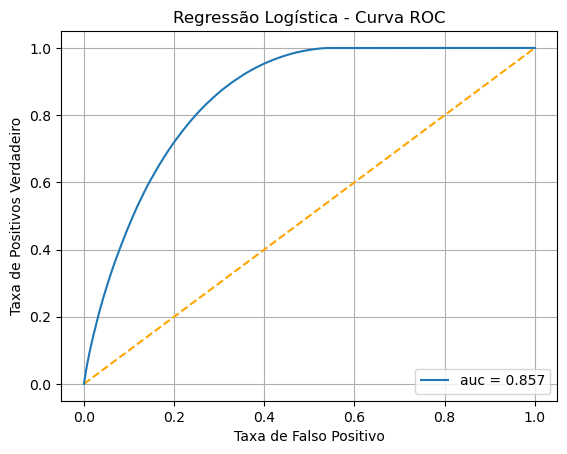

In [58]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_log, tpr_log, label='auc = {:.3f}'.format(auc_log))
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Regressão Logística - Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 5.3 Floresta Aleatória

### 5.3.1 Treinamento do Modelo - 50 Árvores

In [78]:
# Floresta aleatoria com 50 arvores e profundidade maxima de 5
rf = RandomForestClassifier(labelCol='DELAY', featuresCol='features_vector', 
                            numTrees=50, maxDepth = 5, 
                            maxBins=20, subsamplingRate=0.6,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                                minInstancesPerNode=2)

pipe_stages_rf = stages + [rf]
pipe_rf  = Pipeline(stages=pipe_stages_rf )
fitted_pipe_rf = pipe_rf.fit(train_df)
pred_rf = fitted_pipe_rf.transform(test_df)

### 5.3.2 Avaliação do Modelo - 50 Árvores

In [79]:
# Crie um avaliador de classificação multiclasse
evaluator_rf = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction", metricName="accuracy")

# Avalie o modelo e obtenha a matriz de confusão
accuracy_rf = evaluator_rf.evaluate(pred_rf)
print(f"Acurácia da Floresta Aleatória (50 árvores): {accuracy_rf}")

# Matriz de confusão
y_true_rf = pred_rf.select(['DELAY']).collect()
y_pred_rf = pred_rf.select(['prediction']).collect()

print(classification_report(y_true_rf, y_pred_rf))

Acurácia da Floresta Aleatória (50 árvores): 0.8049350488638568
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    767186
           1       1.00      0.46      0.63    428790

    accuracy                           0.80   1195976
   macro avg       0.88      0.73      0.75   1195976
weighted avg       0.85      0.80      0.78   1195976



In [80]:
pred_rf_pd = pred_rf.select('DELAY', 'prediction', 'probability').toPandas()
pred_rf_pd['probability'] = pred_rf_pd['probability'].map(lambda x: list(x))
pred_rf_pd['encoded_DELAY'] = pred_rf_pd['DELAY'].map(lambda x: np.eye(2)[int(x)])

y_pred_rf = np.array(pred_rf_pd['probability'].tolist())
y_true_rf = np.array(pred_rf_pd['encoded_DELAY'].tolist())

fpr_rf, tpr_rf, threshold_rf = roc_curve(y_score=y_pred_rf[:,0], y_true=y_true_rf[:,0])
auc_rf = auc(fpr_rf, tpr_rf)
print('AUC Floresta Aleatória: {:.3f}'.format(auc_rf))


AUC Floresta Aleatória: 0.728


/tmp/ipykernel_12783/3232007868.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


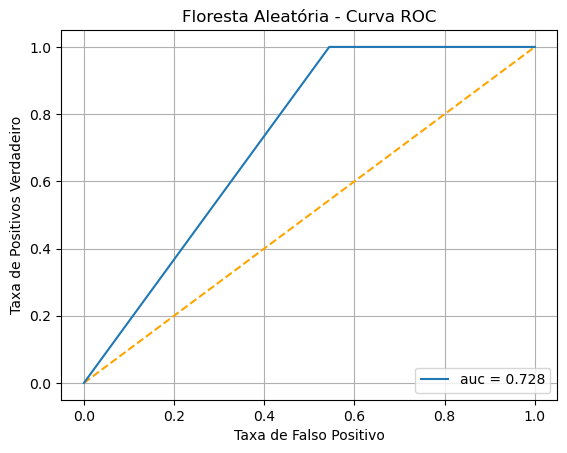

In [81]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_rf, tpr_rf, label='auc = {:.3f}'.format(auc_rf))
#plt.plot(fpr_log, tpr_log)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Floresta Aleatória - Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 5.4 Floresta Aleatória Tunada

### 5.4.1 Obtenção dos melhores hiperparâmetros da Floresta Aleatória

In [63]:
# profundidade da árvore de 5 e 10 e testando com 25 e 50 árvores

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5,10]).addGrid(rf.numTrees, [25, 50]).build()

cv = CrossValidator(estimator=pipe_rf, 
                    evaluator=BinaryClassificationEvaluator(labelCol='DELAY', metricName='areaUnderROC'),
                    estimatorParamMaps=paramGrid,
                    numFolds=5, parallelism=2) #número de folds = 5



In [64]:
bestModel_rf = cv.fit(toy_df) #obtencao do melhor modelo

In [65]:
bestModel_rf.avgMetrics

m_depth = [5, 10]
n_trees = [25, 50]
num_trees = [n for n in n_trees for m in m_depth]
max_depth = [m for n in n_trees for m in m_depth]

roc_auc_df = pd.DataFrame({'areaUnderROC':bestModel_rf.avgMetrics,
                        'Number of Trees': num_trees, 
                        'Max Depth': max_depth})

roc_auc_df.sort_values(by='areaUnderROC', ascending=False)

,areaUnderROC,Number of Trees,Max Depth
3,0.809017,50,10
2,0.807734,50,5
1,0.768394,25,10
0,0.766310,25,5


In [66]:
#obter o melhor numero de arvores e profundidade
max_roc_auc = roc_auc_df['areaUnderROC'].max()
linha_max_roc_auc = roc_auc_df.loc[roc_auc_df['areaUnderROC'] == max_roc_auc]
depth = linha_max_roc_auc['Max Depth'].values[0]
tree = linha_max_roc_auc['Number of Trees'].values[0]
print('Profundidade Ótima: {:.3f}'.format(depth))
print('Número de Árvores Ótimo: {:.3f}'.format(tree))


Profundidade Ótima: 10.000
Número de Árvores Ótimo: 50.000


### 5.4.2 Treinamento do Modelo - Floresta Ótima

In [67]:
rf_best = RandomForestClassifier(labelCol='DELAY', featuresCol='features_vector',
                                 numTrees=tree, maxDepth = depth,
                                 maxBins=20, subsamplingRate=0.6,
                                 minInfoGain= 1e-05,
                                 featureSubsetStrategy='all',
                                 minInstancesPerNode=2)

pipe_stages_rf_best = stages + [rf_best]
pipe_rf_best  = Pipeline(stages=pipe_stages_rf_best )
fitted_pipe_rf_best = pipe_rf_best.fit(train_df)
pred_rf_best = fitted_pipe_rf_best.transform(test_df)


### 5.4.3 Avaliação do Modelo - Florestá Ótima

In [73]:
# Crie um avaliador de classificação multiclasse
evaluator_rf_best = MulticlassClassificationEvaluator(labelCol="DELAY", predictionCol="prediction", metricName="accuracy")

# Avalie o modelo e obtenha a matriz de confusão
accuracy_rf_best = evaluator_rf.evaluate(pred_rf_best)
print(f"Acurácia da Floresta Aleatória Ótima (50 árvores): {accuracy_rf_best}")

# Matriz de confusão
y_true_rf_best = pred_rf_best.select(['DELAY']).collect()
y_pred_rf_best = pred_rf_best.select(['prediction']).collect()

print(classification_report(y_true_rf_best, y_pred_rf_best))

Acurácia da Floresta Aleatória Ótima (50 árvores): 0.8082051813748771
              precision    recall  f1-score   support

           0       0.78      0.99      0.87    767186
           1       0.95      0.49      0.65    428790

    accuracy                           0.81   1195976
   macro avg       0.86      0.74      0.76   1195976
weighted avg       0.84      0.81      0.79   1195976



In [75]:
pred_rf_best_pd = pred_rf_best.select('DELAY', 'prediction', 'probability').toPandas()
pred_rf_best_pd['probability'] = pred_rf_best_pd['probability'].map(lambda x: list(x))
pred_rf_best_pd['encoded_DELAY'] = pred_rf_best_pd['DELAY'].map(lambda x: np.eye(2)[int(x)])

y_pred_rf_best = np.array(pred_rf_best_pd['probability'].tolist())
y_true_rf_best = np.array(pred_rf_best_pd['encoded_DELAY'].tolist())

fpr_rf_best, tpr_rf_best, threshold_rf_best = roc_curve(y_score=y_pred_rf_best[:,0], y_true=y_true_rf_best[:,0])
auc_rf_best = auc(fpr_rf_best, tpr_rf_best)
print('AUC Floresta Aleatória Ótima: {:.3f}'.format(auc_rf_best))

AUC Floresta Aleatória Ótima: 0.808


/tmp/ipykernel_12783/1700572059.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


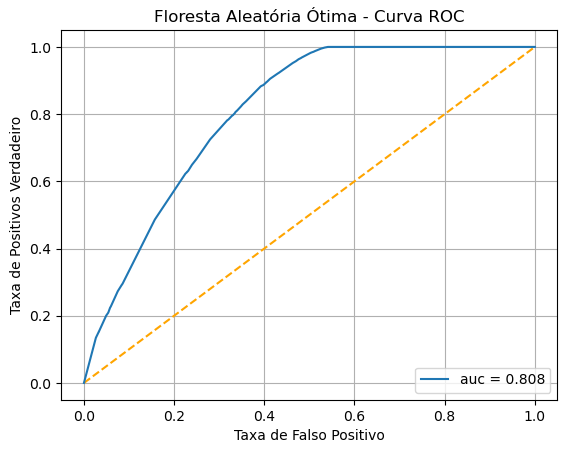

In [76]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_rf_best, tpr_rf_best, label='auc = {:.3f}'.format(auc_rf_best))
#plt.plot(fpr_log, tpr_log)
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Floresta Aleatória Ótima - Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 5.5 Análise de Desempenho dos Modelos

/tmp/ipykernel_12783/3414889633.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


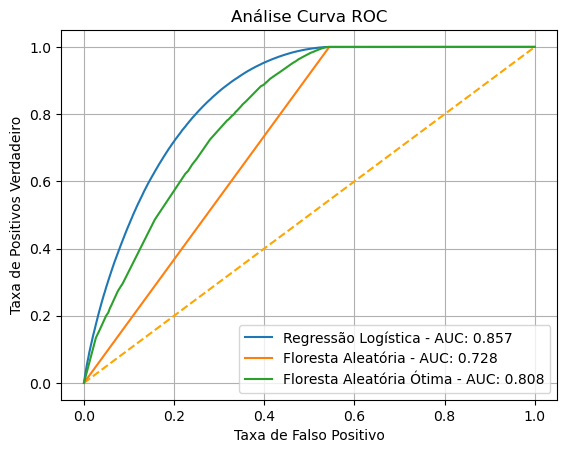

In [82]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_log, tpr_log, label='Regressão Logística - AUC: {:.3f}'.format(auc_log))
plt.plot(fpr_rf, tpr_rf, label='Floresta Aleatória - AUC: {:.3f}'.format(auc_rf))
plt.plot(fpr_rf_best, tpr_rf_best, label='Floresta Aleatória Ótima - AUC: {:.3f}'.format(auc_rf_best))
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Positivos Verdadeiro')
plt.title('Análise Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# como cancelar o cache
df.unpersist()